In [23]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import e

In [3]:
#Defining Functions / Model

def model(t, Z, host_growth, ν_x, φ, μ_v, δ, μ_v_):
    
    S = Z[0] #Susceptible Hosts
    I = Z[1] #Infected Hosts
    P = Z[2] #Internal viruses from host nucleotide recycling
    D = Z[3] #Internal viruses from de novo nucleotide synthesis
    V = Z[4] #Free (extracellular) viruses
    
    ν_p = (P + D) / (I + P + D) #mimics delay in internal viral production and host 
                                #lysis, due to internal assymbly of viral progeny 
    adsorption = φ * S * V
    nucl_recyc = ν_p * μ_v * I
    lysis = ν_p * δ
    de_novo_syn = ν_p * μ_v_ * I
    
    #Host
    dSdt = (host_growth * S) - ((1 - ν_x) * adsorption)
    dIdt = (host_growth * I) + ((1 - ν_x) * adsorption) - nucl_recyc - lysis * I
    
    #Intracellular
    dPdt = nucl_recyc - (lysis * P)
    dDdt = de_novo_syn + (ν_x * adsorption) - (lysis * D)
    
    #Free
    dVdt = - (ν_x * adsorption) + (lysis * (P + D))
    
    return dSdt, dIdt, dPdt, dDdt, dVdt

**Five model parameters controlling infection dynamics:**

virus adsorption $φ$: fitted using data from adsorbtion experiments.

host growth rate $μ_h$, host nucleotide recycling rate $μ_v$, de novo nucleotide synthesis rate $μ_{v}'$, and lysis rate $δ$ where fitted using population-level observations of host-virus dynamics. Estimates of parameter distribution were generated using the Metropolis algorithm. 

Nucleotide recycling and synthesis rates are sensitive to irradiance level. Recycling accelerated by lower irradience, and synthesis accelerated by higher irradiance (Fig. 5 (a, b)). 

Host growth rate is also sensitive to irradiance level; I did my best to pick a max growth rate out of the plausible range given at different irradience levels, ie. chose an average irradience level consistant with LD experiments. 

In [4]:
#Initial Conditions, Based off LD data,
#Moving forward, refered to as "base values"

s0 = 1.5 * 10 ** 14 #NT ml^-1, Fig. S5 (c)
i0 = 0
p0 = 0.0001 #Accounts for division by zero
d0 = 0.0001
v0 = 2.7 * 10 ** 12 #NT ml^-1, Fig. S4

z0 = [s0, i0, p0, d0, v0]

#Args
μ_h = .85                     #Host growth rate Fig. 3 (a), irradience 300

V_ind = 4 * 10 ** 5           #NT per individual virus, Table S1
S_ind = 1.42 * 10 ** 8        #NT per individual host, Table S1
ν_x = V_ind / (V_ind + S_ind) #Proportion of NT from free virus, 

φ = 3.5 * 10 ** -10           #ml / (NT * day), Virus-Host adsorption rate, Table S1
μ_v = 3                       #per day, Max host nucleotide recycling rate, Fig. 5 (a) LD
δ = .45                       #Max lysis rate
μ_v_ = 1.6                    #per day, Max de novo nucleotide synthesis rate, Fig. 5 (b) LD

Lysis rates where taken from [here](https://www.sciencedirect.com/science/article/pii/S0079661117301593).

In [6]:
#Time in days
t  = [0, 7]

#Solving for Solution
sol = solve_ivp(model, t, z0, args=(μ_h, ν_x, φ, μ_v, δ, μ_v_), method='DOP853', max_step=.1, rtol=10**-5, atol=10**-8)

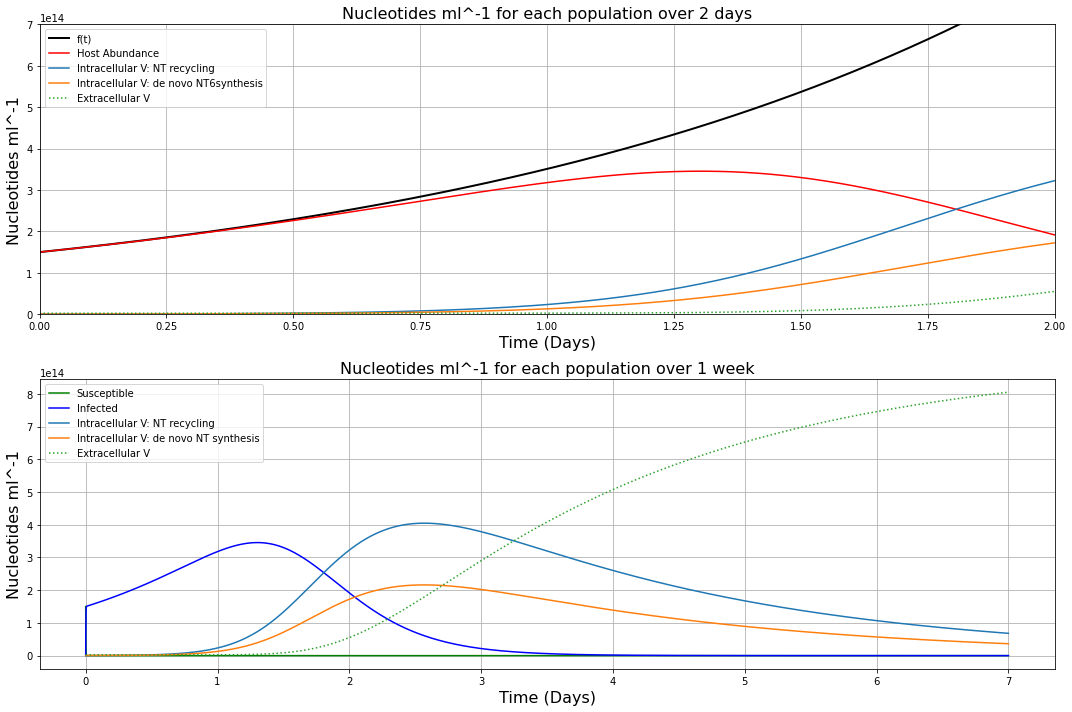

In [24]:
#Plot results
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

exp_host = lambda t : s0 * e ** (μ_h * t)
exp_virus = lambda t: v0 * e ** (μ_v * t)

ax.plot(sol.t, [exp_host(t) for t in sol.t], color='black', label='f(t)', linewidth = 2)
ax.plot(sol.t, sol.y[0] + sol.y[1], 'r', label='Host Abundance')
#ax.plot(sol.t, sol.y[0], 'g', label='Susceptible', linewidth = 2)
#ax.plot(sol.t, sol.y[1], 'b', label='Infected', linewidth = 2)
ax.plot(sol.t, sol.y[2], '-', label='Intracellular V: NT recycling')
ax.plot(sol.t, sol.y[3], '-', label='Intracellular V: de novo NT6synthesis')
ax.plot(sol.t, sol.y[4], ':', label='Extracellular V')

#ax2.plot(sol.t, sol.y[0] + sol.y[1], 'r', label='Host Abundance')
#ax2.plot(sol.t, [exp_host(t) for t in sol.t], color='black', label='.85')
ax2.plot(sol.t, sol.y[0], 'g', label='Susceptible')
ax2.plot(sol.t, sol.y[1], 'b', label='Infected')
ax2.plot(sol.t, sol.y[2], '-', label='Intracellular V: NT recycling')
ax2.plot(sol.t, sol.y[3], '-', label='Intracellular V: de novo NT synthesis')
ax2.plot(sol.t, sol.y[4], ':', label='Extracellular V')

ax.set_xlabel('Time (Days)', fontsize = 16)
ax.set_ylabel('Nucleotides ml^-1', fontsize = 16)
ax.set_title('Nucleotides ml^-1 for each population over 2 days', fontsize = 16)

ax2.set_xlabel('Time (Days)', fontsize = 16)
ax2.set_ylabel('Nucleotides ml^-1', fontsize = 16)
ax2.set_title('Nucleotides ml^-1 for each population over 1 week', fontsize = 16)

ax.legend()
ax.grid()
ax.set_xlim([0, 2]); ax.set_ylim([0, 7 * 10 ** 14])
#ax2.set_xlim([0, 7]); ax2.set_ylim([0, 2 * 10 ** 15])

ax2.legend()
ax2.grid()
fig.tight_layout()
plt.show()

## Finding the equalibrium of state variables, assuming only one max

In [47]:
#Finding the equalibrium of state variables, assuming only one max and min.
state_vars = ["Suseptible", "Infected", "NT Recycling", "De novo Synthesis", "Free Virus"]   
groups = {}

for i in range(1, 4):
    solutions = sol.y[i]
    
    max_y = np.max(solutions) #find max and min of each state variable 
    #min_y = np.min(solutions)

    #Find time at which max and min happen (index placement)
    eq_max = np.where(solutions == max_y)[0][0]
    #eq_min = np.where(solutions == min_y)[0][0]

    groups[state_vars[i] + '_max'] = [sol.t[eq_max],    sol.y[0][eq_max],
                                      sol.y[1][eq_max], sol.y[2][eq_max], 
                                      sol.y[3][eq_max], sol.y[4][eq_max]]
    
    #groups[state_vars[i] + '_min'] = [sol.t[eq_min],    sol.y[0][eq_min],
                                      #sol.y[1][eq_min], sol.y[2][eq_min], 
                                      #sol.y[3][eq_min], sol.y[4][eq_min]]
    
    t_max = groups[state_vars[i] + '_max'][0] #, groups[state_vars[i] + '_min'][0]
    S_max = groups[state_vars[i] + '_max'][1] #, groups[state_vars[i] + '_min'][1]
    I_max = groups[state_vars[i] + '_max'][2] #, groups[state_vars[i] + '_min'][2] 
    P_max = groups[state_vars[i] + '_max'][3] #, groups[state_vars[i] + '_min'][3]
    D_max = groups[state_vars[i] + '_max'][4] #, groups[state_vars[i] + '_min'][4]
    V_max = groups[state_vars[i] + '_max'][5] #, groups[state_vars[i] + '_min'][5]
               
    print(f"At max {state_vars[i]: <15}")
    print(f"t = {t_max: <22e}")
    print(f"S = {S_max: <22e}")
    print(f"I = {I_max: <22e}")
    print(f"P = {P_max: <22e}")
    print(f"D = {D_max: <22e}")
    print(f"V = {V_max: <22e}")
    print()

At max Infected       
t = 1.301380e+00          
S = -1.988753e-08         
I = 3.454433e+14          
P = 7.306520e+13          
D = 3.937632e+13          
V = 4.165712e+12          

At max NT Recycling   
t = 2.568942e+00          
S = -1.807075e-08         
I = 6.070872e+13          
P = 4.046810e+14          
D = 2.161126e+14          
V = 1.794169e+14          

At max De novo Synthesis
t = 2.568431e+00          
S = 1.807078e-08          
I = 6.077984e+13          
P = 4.046809e+14          
D = 2.161126e+14          
V = 1.792869e+14          



In [74]:
#Defining functions
    
def dIdt(S, I, P, D, V, μ_h, ν_x, φ, μ_v, δ, μ_v_):
    
    ν_p = (P + D) / (I + P + D)
    
    adsorption = φ * S * V
    nucl_recyc = ν_p * μ_v * I
    lysis = ν_p * δ
    
    return (μ_h * I) + ((1 - ν_x) * adsorption) - nucl_recyc - lysis * I


def dPdt(S, I, P, D, V, μ_h, ν_x, φ, μ_v, δ, μ_v_):
    
    ν_p = (P + D) / (I + P + D)
    
    nucl_recyc = ν_p * μ_v * I
    lysis = ν_p * δ
    
    return nucl_recyc - (lysis * P)
    
    
def dDdt(S, I, P, D, V, μ_h, ν_x, φ, μ_v, δ, μ_v_): 
    
    ν_p = (P + D) / (I + P + D)
    
    adsorption = φ * S * V
    lysis = ν_p * δ
    de_novo_syn = ν_p * μ_v_ * I
    
    return de_novo_syn + (ν_x * adsorption) - (lysis * D)

In [249]:
#Double checking Infected values with state equations
S_max = groups[state_vars[1] + '_max'][1]
I_max = groups[state_vars[1] + '_max'][2]
P_max = groups[state_vars[1] + '_max'][3]
D_max = groups[state_vars[1] + '_max'][4]
V_max = groups[state_vars[1] + '_max'][5]

dIdt_max = round(dIdt(S_max, I_max, P_max, D_max, V_max, μ_h, ν_x, φ, μ_v, δ, μ_v_), 5)

print(f"dIdt evaluates to {dIdt_max: e} at the given values of ")
print(f"I = {I_max: e}, P = {P_max: e}, and D = {D_max: e}")
print()

#Double checking  values with state equations
S_max = groups[state_vars[2] + '_max'][1]
I_max = groups[state_vars[2] + '_max'][2]
P_max = groups[state_vars[2] + '_max'][3]
D_max = groups[state_vars[2] + '_max'][4]
V_max = groups[state_vars[2] + '_max'][5]

dPdt_max = round(dPdt(S_max, I_max, P_max, D_max, V_max, μ_h, ν_x, φ, μ_v, δ, μ_v_), 5)

print(f"dPdt evaluates to {dPdt_max: e} at the given values of")
print(f"I = {I_max: e}, P = {P_max: e}, and D = {D_max: e}")
print()

#Double checking  values with state equations
S_max = groups[state_vars[3] + '_max'][1]
I_max = groups[state_vars[3] + '_max'][2]
P_max = groups[state_vars[3] + '_max'][3]
D_max = groups[state_vars[3] + '_max'][4]
V_max = groups[state_vars[3] + '_max'][5]

dDdt_max = round(dDdt(S_max, I_max, P_max, D_max, V_max, μ_h, ν_x, φ, μ_v, δ, μ_v_), 5)

print(f"dDdt evaluates to {dDdt_max: e} at the given values of")
print(f"I = {I_max: e}, P = {P_max: e}, and D = {D_max: e}")
print()



dIdt evaluates to -2.261497e+10 at the given values of 
I =  3.454439e+14, P =  7.339368e+13, and D =  3.955144e+13

dPdt evaluates to -8.434204e+09 at the given values of
I =  6.069906e+13, P =  4.046810e+14, and D =  2.161126e+14

dDdt evaluates to  1.371562e+09 at the given values of
I =  6.078261e+13, P =  4.046809e+14, and D =  2.161126e+14



## Sensitivity of host dynamics to transfer parameters: single parameter variation 

**Recreation of Figure 4 in "Light regulation .... " Thamatrakoln 2018.**

In [20]:
#Solving for Solution
#varying μ_v = [3.8, 13]
sol1 = solve_ivp(model, t, z0, args=(.65, ν_x, φ, 3.8, .6, .55), max_step=.1)
sol2 = solve_ivp(model, t, z0, args=(.65, ν_x, φ, 13, .6, .45), max_step=.1)

#varying μ_v' = [0, 1.3]
sol3 = solve_ivp(model, t, z0, args=(.65, ν_x, φ, 3.9, .6, 0), max_step=.1)
sol4 = solve_ivp(model, t, z0, args=(.65, ν_x, φ, 3.4, .6, 1.3), max_step=.1)

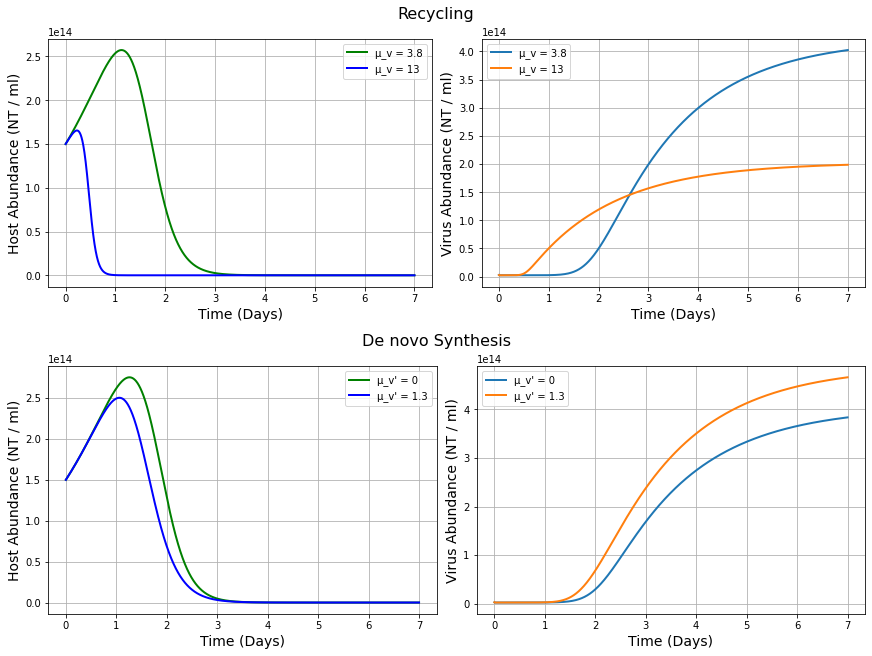

In [21]:
#Host / Viral Abundance at particular values of various transfer parameters
row_labels = ['Recycling', 'De novo Synthesis']
column_labels = [['μ_v = 3.8', 'μ_v = 13'], ["μ_v' = 0", "μ_v' = 1.3"]]
sols = [[sol1, sol2], [sol3, sol4]]

fig = plt.figure(constrained_layout=True, figsize=(12, 9))

#Create 2x1 subfigures
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'{row_labels[row]}', fontsize = 16)
    
    #Create 1x2 subplots per subfigure
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        
        sol = sols[row]

        ax.set_xlabel('Time (Days)', fontsize = 14)
        
        if col == 0:
            host_abundance1 = [sol[0].y[0][i] + sol[0].y[1][i] for i in range(len(sol[0].t))]
            host_abundance2 = [sol[1].y[0][i] + sol[1].y[1][i] for i in range(len(sol[1].t))]
            ax.plot(sol[0].t, host_abundance1, 'g', label=column_labels[row][0], linewidth = 2)
            ax.plot(sol[1].t, host_abundance2, 'b', label=column_labels[row][1], linewidth = 2)
            
            ax.set_ylabel('Host Abundance (NT / ml)', fontsize = 14)
            
        else:
            ax.plot(sol[0].t, sol[0].y[4], label=column_labels[row][0], linewidth = 2)
            ax.plot(sol[1].t, sol[1].y[4], label=column_labels[row][1], linewidth = 2)
            ax.set_ylabel('Virus Abundance (NT / ml)', fontsize = 14)
            
        ax.legend(); ax.grid()


In [7]:
#Sensitivity to perturbatios in host growth rate, using base values

growth_rates = [.1, .3, .5, .7, .9]
growth_rate_dict = {}

for rate in growth_rates:
    growth_rate_dict[rate] = solve_ivp(model, t, z0, args=(rate, ν_x, φ, μ_v, δ, μ_v_))

In [8]:
#Sensitivity to perturbatios in NT recycling rate, using base values
recycl_rates = [1.2, 2, 3, 5, 10, 15]
recycl_rate_dict = {}

for rate in recycl_rates:
    recycl_rate_dict[rate] = solve_ivp(model, t, z0, args=(μ_h, ν_x, φ, rate, δ, μ_v_))

In [9]:
#Sensitivity to perturbatios in de novo NT synthesis rate, using base values
synth_rates = [.1, .3, .5, 1, 2]
synth_rate_dict = {}

for rate in synth_rates:
    synth_rate_dict[rate] = solve_ivp(model, t, z0, args=(μ_h, ν_x, φ, μ_v, δ, rate))

In [18]:
#Sensitivity to perturbatios in adsorption rate, using base values
adsorp_rates = [10**-9, 10**-10, 10**-11, 10**-12] #these are large gaps....
adsorp_rate_dict = {}

for rate in adsorp_rates:
    adsorp_rate_dict[rate] = solve_ivp(model, t, z0, args=(μ_h, ν_x, rate, μ_v, δ, μ_v_))

In [19]:
#Sensitivity to perturbatios in lysis rate, using base values
lysis_rates = [.1, .3, .5, .7, .9] #these are large gaps....
lysis_rate_dict = {}

for rate in lysis_rates:
    lysis_rate_dict[rate] = solve_ivp(model, t, z0, args=(μ_h, ν_x, φ, μ_v, rate, μ_v_))

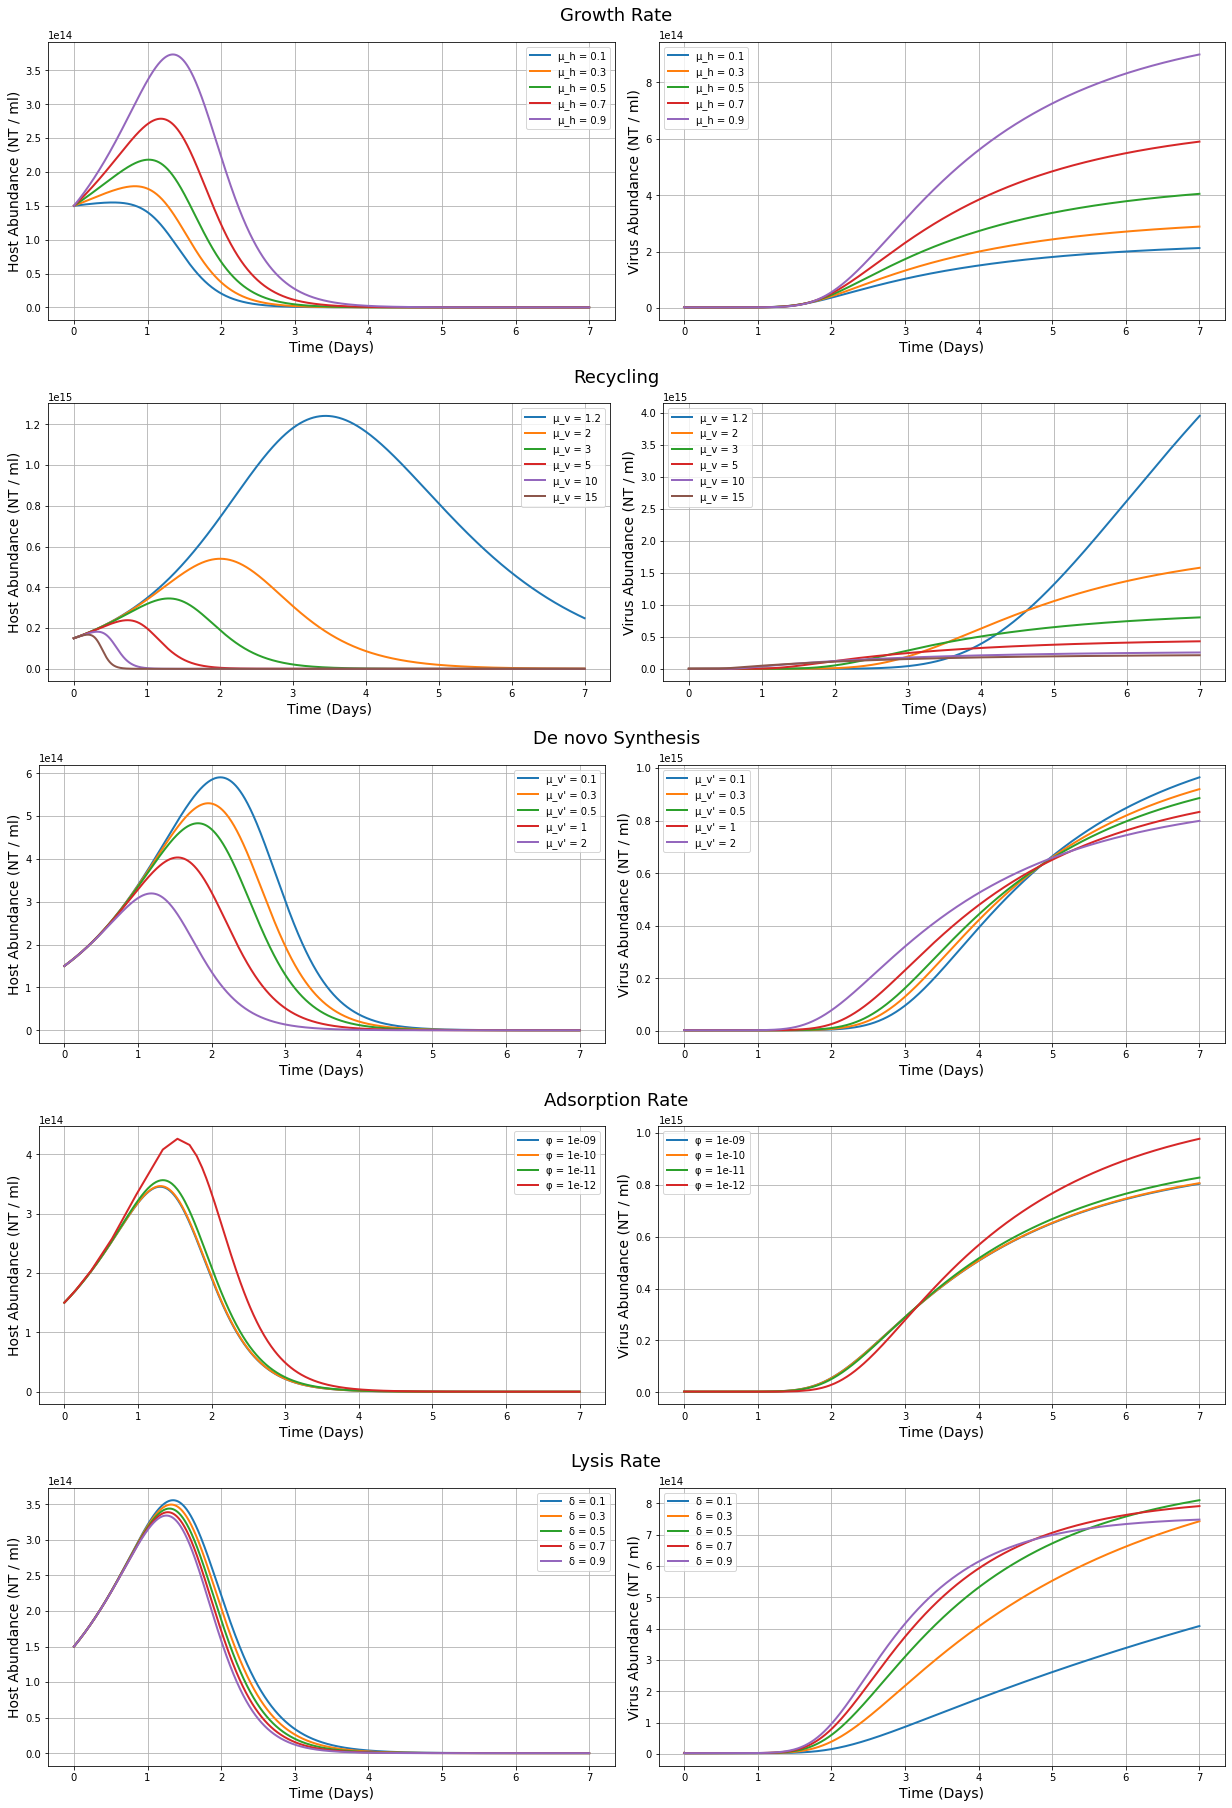

In [22]:
#Host / Viral Abundance at particular values of various transfer parameters

labels = [('Growth Rate', 'μ_h'), ('Recycling', 'μ_v'), ('De novo Synthesis', "μ_v'"), ('Adsorption Rate', 'φ'), ('Lysis Rate', 'δ')]
dicts  = [growth_rate_dict, recycl_rate_dict, synth_rate_dict, adsorp_rate_dict, lysis_rate_dict]

fig = plt.figure(constrained_layout=True, figsize=(17, 25))
subfigs = fig.subfigures(nrows=5, ncols=1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(labels[row][0], fontsize = 18)
    axs = subfig.subplots(nrows=1, ncols=2)
    
    for col, ax in enumerate(axs):
        focus = dicts[row]
        ax.set_xlabel('Time (Days)', fontsize = 14)
           
        for rate in focus:
            time = focus[rate].t
            
            if col == 0: #plot host-abundance
                susceptible = focus[rate].y[0]
                infected = focus[rate].y[1]
                host_abundance = [susceptible[i] + infected[i] for i in range(len(time))]

                ax.plot(time, host_abundance, label= str(labels[row][1]) + ' = ' + str(rate) , linewidth = 2)
                ax.set_ylabel('Host Abundance (NT / ml)', fontsize = 14)

            else: #plot viral-abundance
                free_virus = focus[rate].y[4]

                ax.plot(time, free_virus, label=str(labels[row][1]) + ' = ' + str(rate), linewidth = 2)
                ax.set_ylabel('Virus Abundance (NT / ml)', fontsize = 14)
                
        ax.legend(); ax.grid()

## Sensitivity of host dynamics to transfer parameters: grouped parameter variation

In [17]:
#Defining irradiance level and evaluating at different group values
#Time in days
t  = [0, 6.6]

#Reported values of host growth, recycling, and de novo synthesis based on irradiance level
#Fixed lysis rate for all

irrad_values = {'irrad_25':   [.45, 6  , 1.9],
                'irrad_150':  [.97, 16 , .41],
                'irrad_300':  [.95, 12 , .26],
                'irrad_500':  [.85, 4  , 1  ],
                'irrad_1000': [.84, 3.8, .9 ],
                'irrad_2000': [.74, 15 , 2  ]}

#Solving for Solution
for level in irrad_values: 
    
    h_growth = irrad_values[level][0]
    recycling = irrad_values[level][1]
    de_novo_synthesis = irrad_values[level][2]
    
    #Converting strings to arguments that hold the solution sets with corresponting title
    locals()[level] = (level, solve_ivp(model, t, z0, args=(h_growth, ν_x, φ, recycling, δ, de_novo_synthesis), max_step=.5))

In [18]:
#Solutions for each light level are stored in the list bellow
irrad_levels = [[irrad_25, irrad_150], 
                [irrad_300, irrad_500], 
                [irrad_1000, irrad_2000]]

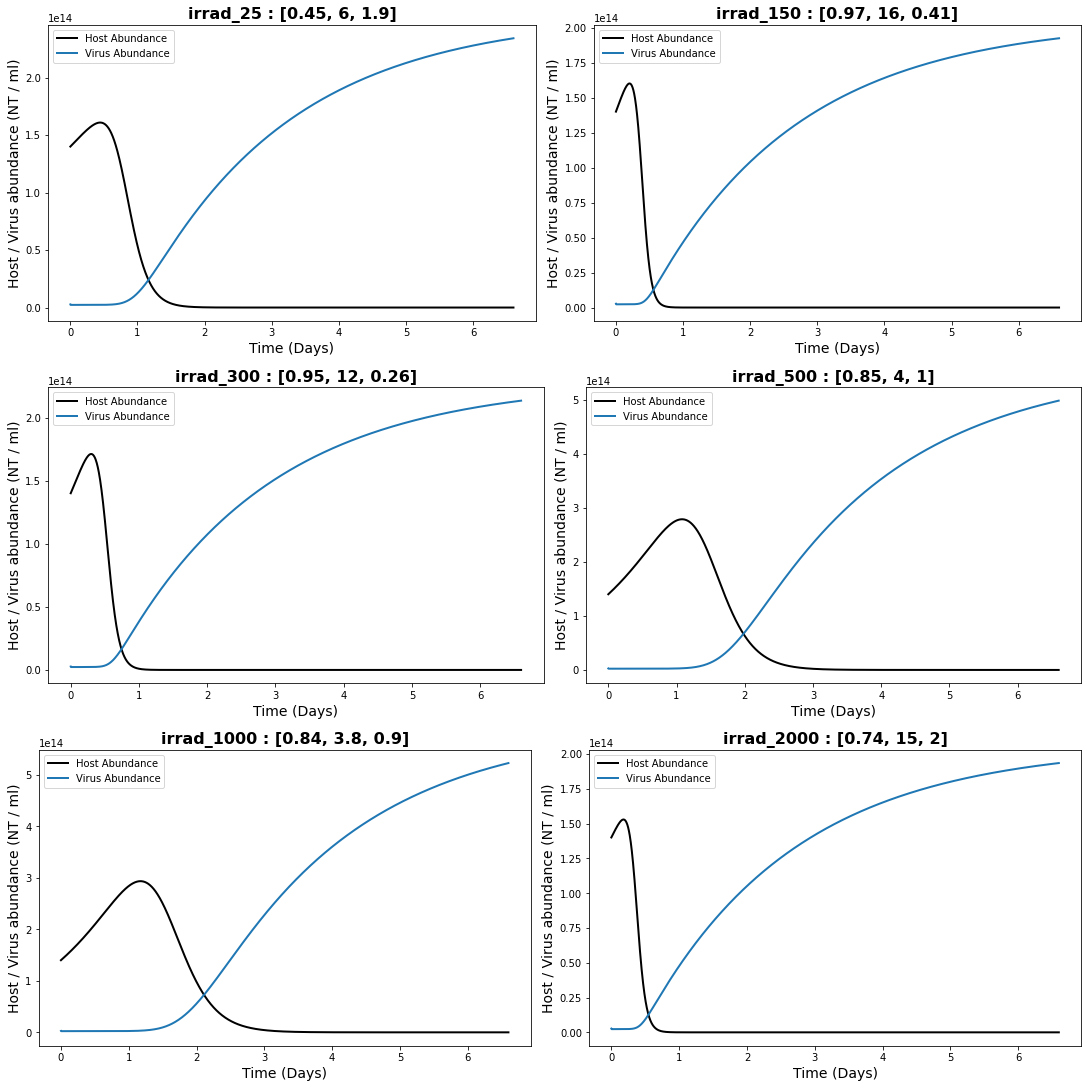

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))

subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):

    #Create 1x2 subplots per subfigure
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        
        title = irrad_levels[row][col][0]
        sol = irrad_levels[row][col][1]
        
        host_abundance = [sol.y[0][i] + sol.y[1][i] for i in range(len(sol.t))]
        ax.plot(sol.t, host_abundance, color='black', label='Host Abundance', linewidth = 2)
        ax.plot(sol.t, sol.y[4], label='Virus Abundance', linewidth = 2)

        ax.set_xlabel('Time (Days)', fontsize = 14)
        ax.set_ylabel('Host / Virus abundance (NT / ml)', fontsize = 14)
        ax.set_title(f'{title} : {irrad_values[title]}', fontweight="bold", fontsize = 16)

        ax.legend()

